## Tarea 2

### Prescriptive analytics: Heuristics for Decision-Making

### Wilmar Calderón

#### 201630701

#### Descripción del ejercicio:

Este documento brinda una solución heurísitca constructiva para el caso del ruteo de arcos capacitado (CARP). Este documento busca dar una solución incial para las instancias de Golden et at. (1983) para encontrar una primera solución factible al problema de ruteo.

Como parte de la parametrización del ejercicio, se plantea como condiciones de las rutas propuestas:

1. Todos los vehículos inician en un nodo marcado como *depósito* (_depot_) y vuelven a terminar en este nodo.
2. Si un arco es recorrido una vez (por la $ruta_{i}$) y atiende la demanda, pero después, otra ruta ($ruta_{i+1}$) utiliza este arco para atender su demanda, el costo de recorrer el arco se le asigna a esta ruta ($ruta_{i+1}$).
3. Si un nodo solo se puede conectar por un arco con el depósito, la ruta tendrá el costo de atender la demanda y de volver al origen.
4. Como primera implementación, no se considera la capacidad de los vehículos en la ruta.

Considerando esto, la implementación se plantea en cuatro secciones:
1. Importación de librerías requeridas y previsualización del problema a resolver.
2. Definición de la función de la solución constructiva
3. Lectura de un archivo para obtener los detalles de la red contenida eenna instancia
4. Ejecución de las 23 instancias de Golden et at. (1983)

## 1. Importación de librerías requeridas

In [9]:
# Importación de librerías utilizadas

import numpy as np #manejo de listas, arreglos y matrices
import re #regular expression: útil para leer facilmente las instancias y obtener la información rápidamente
import os #requerido para la lectura de los archivos .dat de las instancias 
import matplotlib.pyplot as plt #grafica
import networkx as nx #módulo para evaluar grafos, redes, rutas más cortas.
import time #módulo para evalaur el tiempo de ejecución de las soluciones

### 1.1 Previsualización del problema a resolver

Esta sección busca hacer un gráfico inicial de la primera instancia de Golden et at. (1983) para identificar de forma visual el tipo de redes a analizar, así como realizar algunas pruebas y ajustes inciiales, como para las expresiones regulares, que se usarán para la lectura de la información de todas las instancias.

In [10]:
## PRIMER EJEMPLO: LEE EL ARCHIVO GDB PARA ILUSTRAR EL CASO DE ESTUDIO: CARP EN REDES.
###     En esta sección se ajustaron los detalles de la REGEX para poder leer los detalles de todas las instancias de Golden

# Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
# Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
file_path = os.path.join(os.getcwd(), "gdb1.dat")
with open(file_path, "r") as file:
    texto = file.read()

# Expresión regular para extraer los atributos de los arcos
arcos = {
    (int(n1), int(n2)): [int(c), int(d)]
    for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
}

# Expresión regular para capturar el número después de "DEPOSITO :"
match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
depot=int(match.groups()[0])

# Expresión regular para capturar el número después de "VEHICULOS :"
match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
veh=int(match1.groups()[0])

# Expresión regular para capturar el número después de "CAPACIDAD :"
match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
veh_cap=int(match2.groups()[0])

#Imprime los parámetros 
print("Nodo del Depósito: ", depot)
print("Número de Vehículos: ",veh)
print("Capacidad de cada Vehículo: ",veh_cap)

Nodo del Depósito:  1
Número de Vehículos:  5
Capacidad de cada Vehículo:  5


In [11]:
# Creación del grafo de ejemplo
G = nx.Graph()

# Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
for (n1, n2), (coste, demanda) in arcos.items():
    G.add_edge(n1, n2, weight=coste, demanda=demanda)


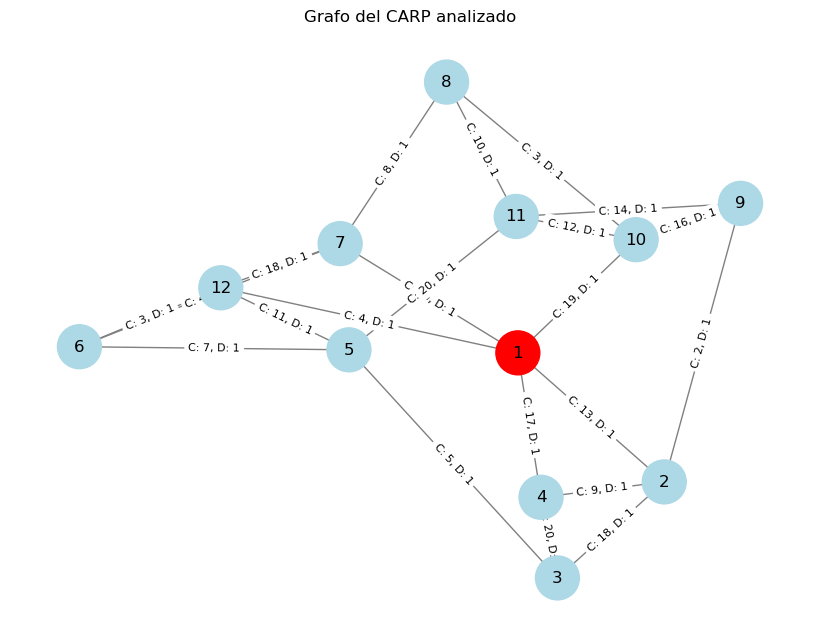

In [12]:
# Dibujo del Grafo. (como no hay coordenadas de distancia, graficado con la forma de nx.spring_layout)

seed=8 #fija la semilla aleatoria para cualquier cambio de vista (por ejemplo random)
pos = nx.spring_layout(G)  # Carga el gráfico basado en el grafo creado

#Creación de las notas de los arcos
edge_labels = {(n1, n2): f"C: {coste}, D: {demanda}" for (n1, n2), (coste, demanda) in arcos.items()}

plt.figure(figsize=(8, 6))
#Definición de los colores (separa el depósito para visualización)
node_colors = ["red" if node == depot else "lightblue" for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Grafo del CARP analizado")
plt.show()

### 2. Definición de la función de la solución constructiva

El método constructivo propuesto sigue el siguiente pseudo-código:

#### *def implementación_CARP*:



$G \leftarrow $ Grafo de la red evaluada

$A \leftarrow $ Matriz de adyacencia del grafo G (con los costos de los arcos)

$D \leftarrow $ Matriz de adyacencia del grafo G (con las demandas almacenadas)

por_visitar $\leftarrow arcos(G)$

$bandera \leftarrow 0$ (bandera útil para recorrer otra ruta si los arcos obtenidos por una ruta más corta ya fueron accedidos)

##### While len (por_visitar)>0, Do:
&emsp; b=$|D_i|$ (calcule cuanta demanda llega a cada nodo con la cardinalidad de los arcos aferentes a este nodo)
    
&emsp; nodo_i= argmax(b) (Seleccione el arco que atiende más demanda)

&emsp; si (bandera==0):

&emsp; &emsp; $ruta_i \leftarrow dijkstra (depot,nodo_i,depot)$

&emsp; si no:

&emsp; &emsp; $ruta_i \leftarrow dijkstra$ (depot,por_visitar[0],depot) (haga la ruta del depot, que pase por el arco que no se ha recorrido y vuelva al depot)

&emsp; for arco in ruta_i:

&emsp; &emsp; si arco está en por_visitar:

&emsp; &emsp; &emsp; por_visitar.remove(arco)

&emsp; &emsp; &emsp; D[(arco)]=0 (actualiza la matriz de adyacencia con demandas para que en la siguiente iteración el algoritmo busque otro nodo)

&emsp; &emsp; &emsp; G[(arco)]["costo"]*=4 (actualiza la matriz de costos para que el arco visitado no sea más parte de la ruta más corta y así el algoritmo de dijkstra bsuque una ruta por otros arcos (diferentes a los marcados))


&emsp; &emsp; si no:

&emsp; &emsp; &emsp; bandera==1 (hecho para que busque en la próxima iteración marcar un arco como visitado)

#### *end*

In [13]:
#Implementación del algoritmo CARP. Considera como parámetros: G: el grafo que se analizará (grafo de NetworkX) y depot: el nodo que correspode al depósito

def carp_imp(G,depot):
    # para seleccionar los primeros candidatos para la asignación, se buscarán esos arcos que atiendan más demanda a un menor costo
    a=nx.adjacency_matrix(G,nodelist=range(1,len(G.nodes())+1))
    d=nx.adjacency_matrix(G,nodelist=range(1,len(G.nodes())+1),weight="demanda")

    #costos de salida de esos nodos
    cost_out=a.todense()

    #inicialización del grafo que se modificará para hacer la asignación de los arcos en diferentes rutas
    graph_i=nx.Graph(a)

    #inicialización de la lista con la cual se validará si se recorren todos los arcos de un grafo
    check=list(graph_i.edges())

    #Listas vacías para almacenar los datos de las rutas, costos y demandas atendidas por rutas
    routes=[]
    costs=[]
    demand_a=[]

    #contador de seguridad para no generar un loop infinito
    cont=0
    #bandera útil apra que el ciclo no se quede parado buscando los mínimos. Se activa cuando el ruteo por método de mínimos empieza 
    num_aux=0


    #Mientras hayan arcos sin ser recorridos
    while len(check)>0 and cont<100000:

        # número de nodos con demanda que recibe este nodo que tiene asociado cada nodo
        conn=d.todense()
        cost_out[cost_out==0] = 1
        b_arc=conn/cost_out
        b_arc[np.isnan(b_arc)] = 0

        #evacuemos primero el que tiene más demanda
        node_i=np.argmax(b_arc.sum(axis=1))
        # print(node_i)
        if node_i==0:
            node_i+=1


        #best route
        if num_aux==0:
            #saquemos la ruta más corta entre el nodo con más demanda y el depósito
            cost,nodes=nx.single_source_dijkstra(graph_i, node_i, depot-1)

            #calculemos el costo original (útil si estamos modificando los costos para seleccionar diferentes rutas)
            cost_aux=nx.single_source_dijkstra(G, node_i+1,depot)[0]

            #asigna los costos de la ruta según los valores originales
            if (cost!=cost_aux):
                cost=cost_aux

            #Si el nodo con mayores demandas no es el depot, vamos a hacer la ruta desde el depot hasta el nodo para dar inicio
            if nodes[0]!=0:
                cost_i,n_i=nx.single_source_dijkstra(G, depot,node_i+1)
                cost+=cost_i
                n_i=[n_i[i]-1 for i in range(len(n_i))]
                n_i.pop(-1)
                nodes=n_i+nodes


        else:
            n_ix,n_fx=check[0]
            #saquemos la ruta más corta entre el nodo del extremo del arco hayado y el depósito
            cost,nodes=nx.single_source_dijkstra(graph_i, n_fx, depot-1)

            #calculemos el costo original (útil si estamos modificando los costos para seleccionar diferentes rutas)
            cost_aux=nx.single_source_dijkstra(G, n_fx+1,depot)[0]

            #asigna los costos de la ruta según los valores originales
            if (cost!=cost_aux):
                cost=cost_aux

            #Si el nodo con mayores demandas no es el depot, vamos a hacer la ruta desde el depot hasta el nodo para dar inicio
            if n_ix!=0:
                cost_i,n_i=nx.single_source_dijkstra(G, depot,n_ix+1)
                cost+=cost_i

                cost+=a[n_ix,n_fx]
                n_i=[n_i[i]-1 for i in range(len(n_i))]
                n_i.pop(-1)
                nodes=n_i+[n_ix]+nodes
            else:
                n_i=[i for i in check[0]]
                cost_i=a[n_ix,n_fx]
                cost+=cost_i
                nodes=n_i+nodes

        #crea la secuencia del recorrido de los arcos de la ruta evaluada
        route_i=[(nodes[i-1],nodes[i]) for i in range(1,len(nodes))]


        dem_i=0
        flag=0
            #evalúa cada nodo de la ruta para saber si está o no ya recorrido
        for r in route_i:
            #si el arco no ha sido recorrido
            if (r in check):
                    #almacena cuanta demanda se está atendiendo en el arco
                dem_i+=d[r[0],r[1]]
                    #en la matriz de demandas se coloca 0 para representar que ya se atendió la demanda
                d[r[0],r[1]]=0
                d[r[1],r[0]]=0
                    #se modifica el grafo para que los arcos sean más costosos (y que el método de RMC no eliga este dentro de la ruta)
                graph_i[r[0]][r[1]]['weight']*=4
                    #modifica la lista para saber que ya se recorrió
                check.remove(r)
                    #si un arco se recorre, activa el condicional para almacenar la información del recorrido
                flag+=1

            else: 
                num_aux+=1
        if flag>0:
            routes.append(route_i)
            demand_a.append(dem_i)
            costs.append(cost)
            num_aux=0
        cont+=1
    return (sum(costs),len(check),routes,demand_a)


### 3. Lectura de un archivo para obtener los detalles de la red contenida eenna instancia


In [14]:
def archivo_ejec(filename):
    # Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
    # Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
    file_path = os.path.join(os.getcwd(), filename+".dat")
    with open(file_path, "r") as file:
        texto = file.read()

    # Expresión regular para extraer los arcos
    arcos = {
        (int(n1), int(n2)): [int(c), int(d)]
        for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
    }

    # Expresión regular para capturar el número después de "DEPOSITO :"
    match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
    depot_i=int(match.groups()[0])

    # Expresión regular para capturar el número después de "VEHICULOS :"
    match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
    veh=int(match1.groups()[0])

    # Expresión regular para capturar el número después de "CAPACIDAD :"
    match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
    veh_cap=int(match2.groups()[0])

    #Imprime los parámetros 
    # print("Nodo del Depósito: ", depot_i)
    # print("Número de Vehículos: ",veh)
    # print("Capacidad de cada Vehículo: ",veh_cap)

    # Creación del grafo 
    G = nx.Graph()

    # Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
    for (n1, n2), (coste, demanda) in arcos.items():
        G.add_edge(n1, n2, weight=coste, demanda=demanda)


    c_t,len1,rt_i,d_i=carp_imp(G,depot_i)

    if(len1==0):
        print("\n PARA LA INSTANCIA "+filename+": \n")
        print("¡Se asignaron correctamente todas las rutas!")
        print("A un costo de:")
        print(c_t)
        print("\n con respecto a la solución: \n")
        print("se atendió la siguiente demanda: ",sum(d_i))
        print("se mediante el siguiente número de rutas: ",len(d_i))
    return c_t

### 4. Ejecución de las 23 instancias de Golden et at. (1983)

In [15]:
costs=np.zeros([23,3])

for i in range(1,24):
    filename="gdb"+str(i)
    start_time = time.time()
    c_i=archivo_ejec(filename)
    finish_time = time.time()
    costs[i-1,0]=int(i)
    costs[i-1,1]=int(c_i)
    costs[i-1,2]=finish_time-start_time




 PARA LA INSTANCIA gdb1: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
660

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  18

 PARA LA INSTANCIA gdb2: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
803

 con respecto a la solución: 

se atendió la siguiente demanda:  26
se mediante el siguiente número de rutas:  22

 PARA LA INSTANCIA gdb3: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
610

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  19

 PARA LA INSTANCIA gdb4: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
636

 con respecto a la solución: 

se atendió la siguiente demanda:  19
se mediante el siguiente número de rutas:  16

 PARA LA INSTANCIA gdb5: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
818

 con respecto a la solución: 

se atendió la siguiente demanda:  26
se mediante

In [16]:
import pandas as pd

## convert your array into a dataframe
df = pd.DataFrame (costs,columns=["Instance","Cost","CPU Time(s)"])

## save to xlsx file

filepath = 'results.xlsx'

df.to_excel(filepath, index=False)

### Si desea correr una instancia, simplemente seleccione el número de la isntancia que desea evaluar:

(modifique el número en la línea que define a "filename")

In [17]:
#Nodifique abajo (cambie 1 por la que usted desee)
filename="gdb"+str(1)
c_i=archivo_ejec(filename)
print("Costo de recorrer la instancia ",c_i)


 PARA LA INSTANCIA gdb1: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
660

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  18
Costo de recorrer la instancia  660
